# Маркетинговая аналитика Яндекс.Афиши

#### Цель проекта:
Cнизить маркетинговые расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Файл visits_log.csv хранит лог сервера с информацией о посещениях сайта, orders_log.csv — информацию о заказах, а costs.csv — информацию о расходах на маркетинг.

###### Структура visits_log.csv
- Uid — уникальный идентификатор пользователя,
- Device — категория устройства пользователя,
- Start Ts — дата и время начала сессии,
- End Ts — дата и время окончания сессии,
- Source Id — идентификатор источника перехода на сайт.

###### Структура orders_log.csv
- Uid — уникальный идентификатор пользователя,
- Buy Ts — дата и время заказа,
- Revenue — сумма заказа.

###### Структура costs.csv
- source_id — идентификатор рекламного источника,
- dt — дата проведения рекламной кампании,
- costs — расходы на эту кампанию.

## 1. Импортируем библиотеки. Загрузим данные и подготовим их к анализу.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
df_list = {'Визиты': visits, 'Заказы':orders, 'Расходы':costs}
for df in df_list:
    print('Данные таблицы {}'.format(df))
    display(df_list[df].head())
    display(df_list[df].info())
    display(df_list[df].duplicated().sum())

Данные таблицы Визиты


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

0

Данные таблицы Заказы


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

0

Данные таблицы Расходы


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

0

Приведем названия столбцов к нижнему регистру и заменим пробел на знак нижнего подчеркивания.

In [4]:
visits.columns = visits.columns.str.lower()
visits.columns = visits.columns.str.replace(' ', '_')
orders.columns = orders.columns.str.lower()
orders.columns = orders.columns.str.replace(' ', '_')

Заменим типы данных там где это необходимо.

In [5]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

проверим нет ли в талице с визитами некорректных сессий

In [6]:
visits.query('end_ts < start_ts')
visits = visits.drop(visits[visits.end_ts < visits.start_ts].index)

## 2. Рассчитаем метрики и построим графики

Посчитаем метрики трёх видов:
- продуктовые,
- метрики электронной коммерции,
- маркетинговые.

### 2.1. Продуктовые метрики

#### Рассчитаем DAU, WAU и MAU. Вычислим средние значения этих метрик за весь период.

In [7]:
visits['session_year']  = visits['start_ts'].astype('datetime64[Y]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week']  = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].dt.date

dau_mean = (
    visits.groupby('session_date')
    .agg({'uid':'nunique'})  
    .mean()
)
wau_mean = (
    visits.groupby(['session_year','session_week'])
    .agg({'uid':'nunique'})
    .mean()    
)
mau_mean = (
    visits.groupby(['session_year','session_month'])
    .agg({'uid':'nunique'})
    .mean()    
)

In [8]:
sessions_mean_list = {'дневная':dau_mean, 'недельная':wau_mean, 'месячная':mau_mean}
for df in sessions_mean_list:
    print('Средняя {} активность пользователей'.format(df))
    display(int(sessions_mean_list[df]))

Средняя дневная активность пользователей


907

Средняя недельная активность пользователей


5621

Средняя месячная активность пользователей


23228

 Отобразим изменения метрик во времени на графиках.

In [9]:
dau = (
    visits.groupby('session_date')
    .agg({'uid':'nunique'})
    .reset_index()
)
wau = (
    visits.groupby(['session_year','session_week'])
    .agg({'uid':'nunique'})
    .reset_index()
)
mau = (
    visits.groupby(['session_year','session_month'])
    .agg({'uid':'nunique'})
    .reset_index()
)


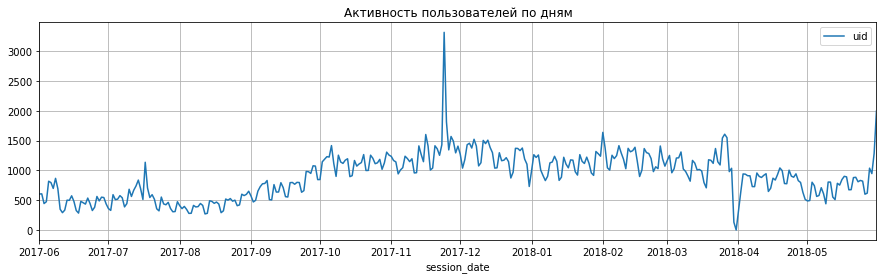

In [10]:
dau.plot.line(x='session_date', y='uid', figsize=(15, 4), grid=True)
plt.title('Активность пользователей по дням')
plt.show()

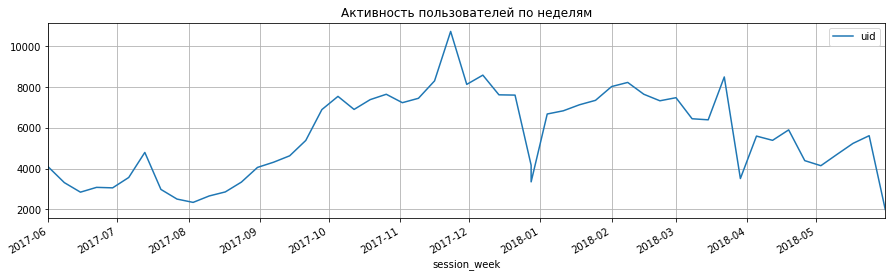

In [11]:
wau.plot.line(x='session_week', y='uid', figsize=(15, 4), grid=True)
plt.title('Активность пользователей по неделям')
plt.show()

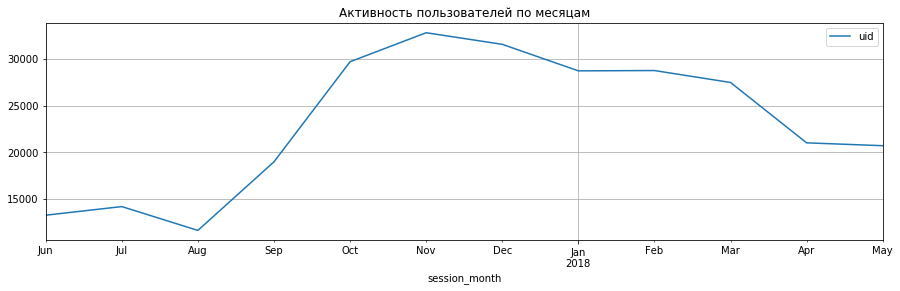

In [12]:
mau.plot.line(x='session_month', y='uid', figsize=(15, 4), grid=True)
plt.title('Активность пользователей по месяцам')
plt.show()

Прослеживается сезонность. Количество уникальных пользователей увеличивается в холодное время года, а именно в период с сентября по апрель.

----





#### Определим, сколько раз за день пользователи в среднем заходят на сайт. Построим график, отражающий изменения метрики во времени

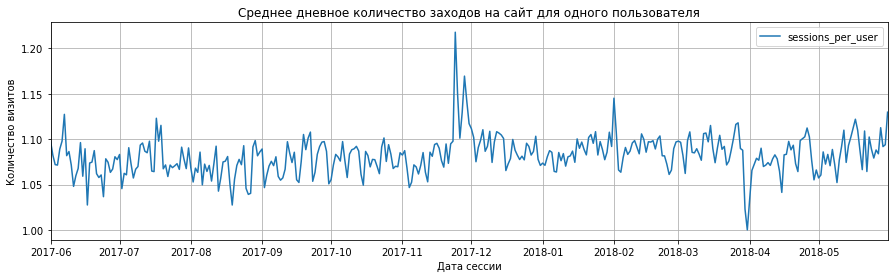

Среднее количество визитов на сайт 1.08 раз.


In [13]:
sessions_per_user = (
    visits.groupby('session_date')
    .agg({'uid':['count','nunique']})
    .reset_index()
)                     
sessions_per_user.columns = ['session_date','n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']

sessions_per_user.plot.line(x='session_date', y='sessions_per_user', figsize=(15, 4), grid=True)
plt.title('Среднее дневное количество заходов на сайт для одного пользователя')
plt.ylabel('Количество визитов')
plt.xlabel('Дата сессии')
plt.show()
print('Среднее количество визитов на сайт {:.2f} раз.'.format(sessions_per_user['sessions_per_user'].mean()))

Пользователи заходят на сайт в среднем чуть больше одного раза. 

---

#### Исследуем, сколько времени пользователи проводят на сайте. Узнаем продолжительность типичной пользовательской сессии за весь период. Построим график распределения, чтобы выбрать подходящую среднюю меру.

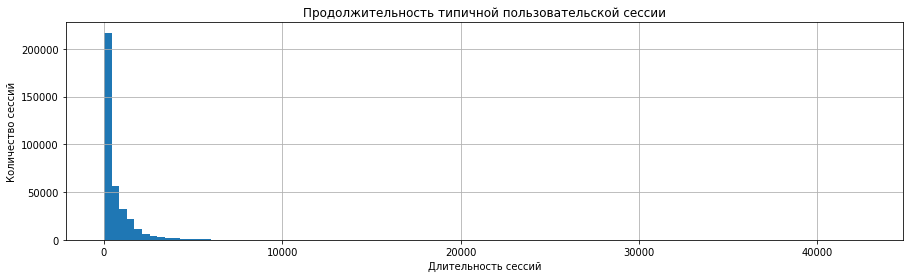

Средняя продолжительность сессии 5 минут.


count    359398.000000
mean        643.042287
std         997.105212
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: session_duration_sec, dtype: float64

In [14]:
visits['session_duration_sec'] = (
    visits['end_ts'] - visits['start_ts']
).dt.seconds
visits['session_duration_sec'].plot.hist(bins=100, figsize=(15, 4), grid=True)
plt.title('Продолжительность типичной пользовательской сессии')
plt.ylabel('Количество сессий')
plt.xlabel('Длительность сессий')
plt.show()
asl = visits['session_duration_sec'].median() / 60
print('Средняя продолжительность сессии {} минут.'.format(int(asl)))
visits['session_duration_sec'].describe()

Средняя сессия пользователей не превышает 5 минут. В пользовательских сессиях есть слишком большие значения (12 часов), поэтому мы использовали медиану. Мода в данном случае не подойдет, так как мода экспоненциального распределения всегда будет низкая.

---



#### Рассчитаем Retention Rate, применяя когортный анализ. Покажим изменения метрики во времени на графике. Найдём средний Retention Rate на второй месяц «жизни» когорт.

In [15]:
customers = visits.groupby('uid').agg({'start_ts' : 'min'}).rename(columns={'start_ts':'first_activity'})
customers['first_activity_month'] = customers['first_activity'].astype('datetime64[M]')

retention = visits.set_index('uid').join(customers, how='left')[['session_month','first_activity_month']]
retention['lifetime'] = ((retention['session_month'] - retention['first_activity_month'])
                         / np.timedelta64(1,'M'))
retention['lifetime'] = retention['lifetime'].round().astype(int)
retention = retention.reset_index()


retention_pivot = retention.pivot_table(
    index='first_activity_month',
    columns='lifetime',
    values='uid',
    aggfunc='sum'
)

retention_pivot = retention_pivot.div(retention_pivot[0], axis=0)

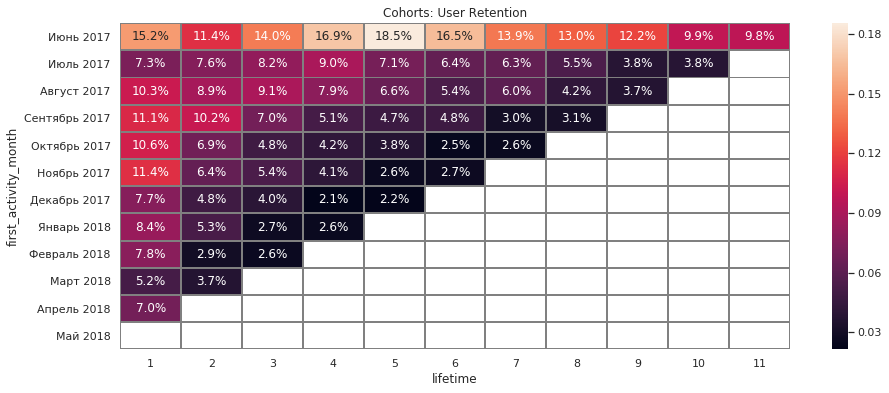

Средний Retention Rate на второй месяц «жизни» когорт 9.3%


In [16]:
sns.set(style='white')
plt.figure(figsize=(15, 6))
plt.title('Cohorts: User Retention')
plt.xlabel('Lifetime')
plt.ylabel('Месяц первой активности')
y_axis_labels = ['Июнь 2017','Июль 2017','Август 2017','Сентябрь 2017','Октябрь 2017','Ноябрь 2017','Декабрь 2017','Январь 2018','Февраль 2018','Март 2018','Апрель 2018','Май 2018'] 
sns.heatmap(retention_pivot[range(1,12)] , annot=True, fmt='.1%', linewidths=1, linecolor='gray', yticklabels=y_axis_labels); 
plt.show()

print('Средний Retention Rate на второй месяц «жизни» когорт {:.1%}'.format(retention_pivot[1].mean()))

Retention Rate на второй месяц «жизни» когорт составляет 9.3%, однако на графике видно, что пользователи из более ранних когорт охотнее возвращались в последующие периоды и во второй месяц «жизни» в частности.

---


### 2.2. Метрики электронной коммерции

#### Исследуем, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки.

In [17]:
first_visits = visits.groupby(['uid'])['start_ts'].min().to_frame().reset_index()
first_order = orders.groupby(['uid'])['buy_ts'].min().to_frame().reset_index()

In [18]:
first_order = first_order.merge(first_visits, on='uid',how='inner')

In [19]:
first_order['order_duration'] = ((first_order['buy_ts'] - first_order['start_ts']).dt.seconds) / 60

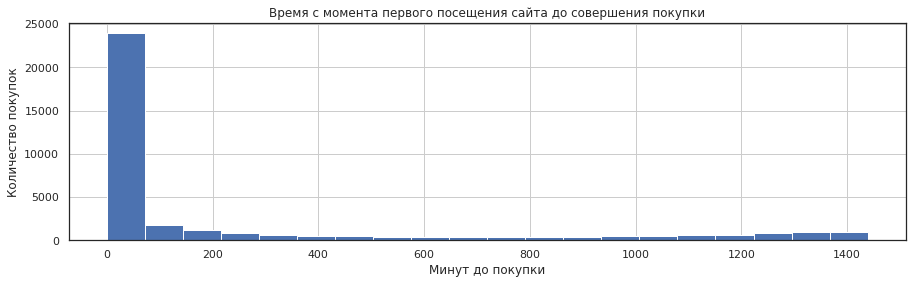

Среднее время с момента первого посещения сайта до совершения покупки 16 минут.


count    36523.000000
mean       249.164691
std        429.742785
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: order_duration, dtype: float64

In [20]:
first_order['order_duration'].plot.hist(bins=20, figsize=(15, 4), grid=True)
plt.title('Время с момента первого посещения сайта до совершения покупки')
plt.ylabel('Количество покупок')
plt.xlabel('Минут до покупки')
plt.show()
order_mean = first_order['order_duration'].median()
print('Среднее время с момента первого посещения сайта до совершения покупки {} минут.'.format(int(order_mean)))

display(first_order['order_duration'].describe())

16 минут, столько в среднем требуется пользователям для совершения покупки. Так же, зглянув на график видно, что практически все покупки совершаются в течении суток.

---

#### Применяя когортный анализ , рассчитаем среднее количество покупок на одного покупателя за 6 месяцев.

- Выделим месяцы из дат в таблицах с заказами и расходами;
- Получим месяц первой покупки каждого покупателя;
- Посчитаем количество новых покупателей (n_buyers) за каждый месяц
- Построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами

In [21]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

first_order_month = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_order_month.columns = ['uid', 'first_order_month']

cohort_sizes = (
    first_order_month.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']

orders = pd.merge(orders,first_order_month, on='uid')
cohorts = (
    orders.groupby(['first_order_month', 'order_month'])
    .agg({'revenue':['count','sum']})
    .reset_index()
)
cohorts.columns = ['first_order_month', 'order_month', 'n_orders', 'sum']

report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['order_per_user'] = report['n_orders'] / report['n_buyers']

output = report.pivot_table(
    index='first_order_month', columns='age', values='order_per_user', aggfunc='mean'
)

display(output.cumsum(axis=1).fillna(''))
print('Среднее количество покупок на одного покупателя за 6 месяцев: {:.1f}'.format(output.cumsum(axis=1)[6].mean()))

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.163618,1.25111,1.33712,1.44884,1.59318,1.70094,1.83737,1.92338,2.02818,2.10381,2.15126,2.19377
2017-07-01,1.136765,1.18877,1.25117,1.30525,1.34269,1.38534,1.41706,1.44306,1.47322,1.4857,1.51326,
2017-08-01,1.118978,1.19781,1.2708,1.32993,1.39197,1.43723,1.47299,1.52993,1.5635,1.59708,,
2017-09-01,1.136381,1.22123,1.28361,1.34715,1.37311,1.41534,1.45719,1.47888,1.50252,,,
2017-10-01,1.143779,1.21613,1.25346,1.28157,1.31129,1.33502,1.35484,1.38364,,,,
2017-11-01,1.179368,1.27665,1.32124,1.37295,1.40627,1.42073,1.44572,,,,,
2017-12-01,1.152635,1.21424,1.26032,1.30116,1.32078,1.34474,,,,,,
2018-01-01,1.121554,1.18796,1.2351,1.25408,1.2772,,,,,,,
2018-02-01,1.121611,1.18242,1.20515,1.22432,,,,,,,,


Среднее количество покупок на одного покупателя за 6 месяцев: 1.5


На 6 месяц жизни когорт, в среднем пользователь совершает 1.5 покупки.

-----

#### Рассчитаем средний чек, применяя группировку по времени совершения покупки. Построим график, отражающий изменения метрики во времени.

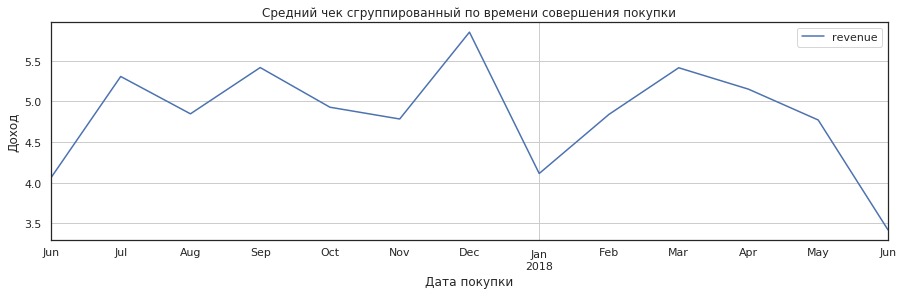

Средний чек покупок 4.85 y.e


In [22]:
orders_per_user = (
    orders.groupby('order_month')
    .agg({'revenue':'mean'})
    .reset_index()
) 

orders_per_user.plot.line(x='order_month', y='revenue', figsize=(15, 4), grid=True)
plt.title('Средний чек сгруппированный по времени совершения покупки')
plt.ylabel('Доход')
plt.xlabel('Дата покупки')
plt.show()
print('Средний чек покупок {:.2f} y.e'.format(orders_per_user['revenue'].median()))

Самый высокий средний чек приходится на декабрь, в этом же месяце происходит пик пользовательской активности.

-----

#### Выясним, как меняется LTV на покупателя по когортам. Рассчитаем средний LTV по когортам за 6 месяцев. 

In [23]:
margin_rate = 1

report['gp'] = report['sum'] * margin_rate
report['ltv'] = report['gp'] / report['n_buyers']

In [24]:
ltv_pivot = report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
)

Отразим изменения метрики во времени на графике с помощью тепловой карты.

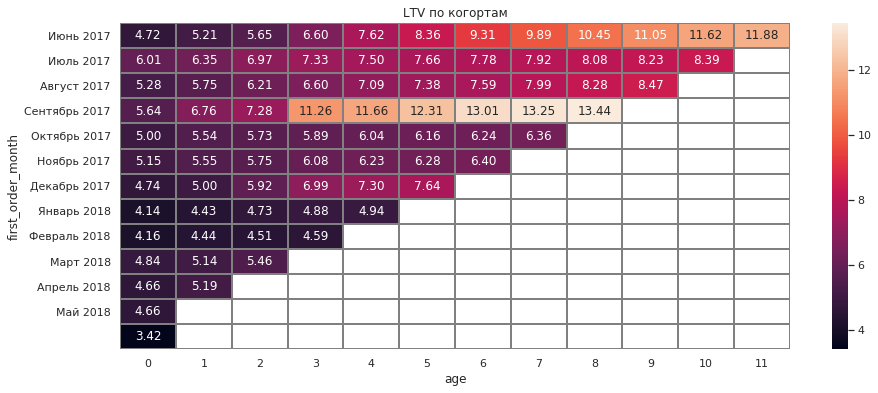

Средний LTV по когортам за 6 месяцев: 8.39 y.e


In [25]:
sns.set(style='white')
plt.figure(figsize=(15, 6))
plt.title('LTV по когортам')
plt.xlabel('Lifetime')
plt.ylabel('Месяц первой активности')
y_axis_labels = ['Июнь 2017','Июль 2017','Август 2017','Сентябрь 2017','Октябрь 2017','Ноябрь 2017','Декабрь 2017','Январь 2018','Февраль 2018','Март 2018','Апрель 2018','Май 2018'] 
sns.heatmap(ltv_pivot.cumsum(axis=1) , annot=True, fmt='.2f', linewidths=1, linecolor='gray', yticklabels=y_axis_labels); 
plt.show()
print('Средний LTV по когортам за 6 месяцев: {:.2f} y.e'.format(ltv_pivot.cumsum(axis=1)[6].mean()))




На шестой месяц жизни когорт, один пользователь в среднем приносит 8.39 y.e. Выделяется среди когорт проживших не менее 6 месяцев когорта Сентябрь'17, для них LTV выше и составляет 13 y.e.

----


### 2.3. Маркетинговые метрики

#### Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам.

In [26]:
print('Общая сумма расходов на маркетинг: {:.2f} y.e'.format(costs['costs'].sum()))

Общая сумма расходов на маркетинг: 329131.62 y.e


In [27]:
costs_grouped = costs.groupby('source_id').agg({'costs':'sum'})

costs_grouped.sort_values(by='costs', ascending=False)

,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


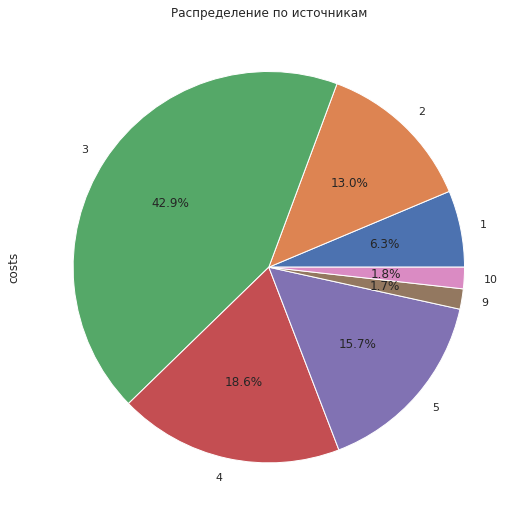

In [28]:
plot = costs_grouped.plot.pie(y='costs', title="Распределение по источникам", legend=False, \
                   autopct='%1.1f%%', figsize=(9, 9))

Визуализируем изменения метрик во времени.

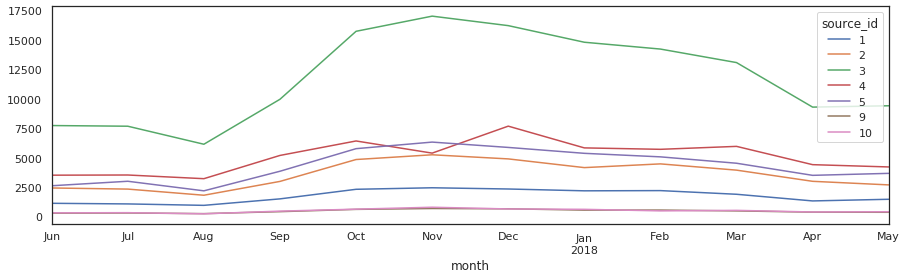

In [29]:
costs['month'] = costs['dt'].astype('datetime64[M]')
fig, ax = plt.subplots(figsize=(15,4))
pd.pivot_table(costs.query('source_id.isin(@costs_grouped.index)'),
              index ='month',
              columns = 'source_id',
              values='costs',
              aggfunc='sum').plot (ax=ax)
plt.show()

Больше всего расходов на маркетинг приходится на источник №3 - 42.9% от общего количества расходов. Меньше всего выделяется на источники №9 и №10 - 1.7% и 1.8% соответсвенно. На графике изменения метрик во времени видно, что траты на рекламу растут, вместе с выявленной сезонностью.

----

#### Рассчитаем средний CAC на одного покупателя для всего проекта и для каждого источника трафика.

Один и тот же пользователь мог заходить на сайт из нескольких источников, поэтому важно определить «главный» источник для каждого и учитывать это в расчётах. Будем считать, что главным будет первый источник перехода. 

In [30]:
users = visits.sort_values(by=['uid','start_ts']).groupby('uid').agg({'source_id':'first',
                                                                     'session_month':'first'})
buyers = users.query('uid in @orders.uid').reset_index()
buyers = buyers.groupby(['source_id']).agg({'uid':'nunique'})

report_costs = buyers.join(costs_grouped)
report_costs['cac'] = report_costs['costs'] / report_costs['uid']
report_costs

,uid,costs,cac
source_id,,,
1,2899,20833.27,7.186364
2,3506,42806.04,12.209367
3,10473,141321.63,13.493901
4,10296,61073.60,5.931779
5,6931,51757.10,7.467479
7,1,NaN,NaN
9,1088,5517.49,5.071222
10,1329,5822.49,4.381106


In [31]:
cac_mean = report_costs['costs'].sum() / report_costs['uid'].sum()
print('Средний CAC на одного покупателя для всего проекта: {:.2f} y.e'.format(cac_mean))

Средний CAC на одного покупателя для всего проекта: 9.01 y.e


Теперь найдем средний CAC на одного покупателя для каждого источника трафика.

In [32]:
costs_grouped_month = costs.groupby(['source_id','month']).agg({'costs':'sum'})

buyers_month = users.query('uid in @orders.uid').reset_index()
buyers_month = buyers_month.groupby(['source_id','session_month']).agg({'uid':'nunique'})
 
report_cost_month = pd.concat([costs_grouped_month,buyers_month], axis=1)
report_cost_month = report_cost_month.reset_index()
report_cost_month.columns = ['source_id', 'month', 'costs', 'n_users']
report_cost_month['cac'] = report_cost_month['costs'] / report_cost_month['n_users']

Отразим изменения метрик на графике.

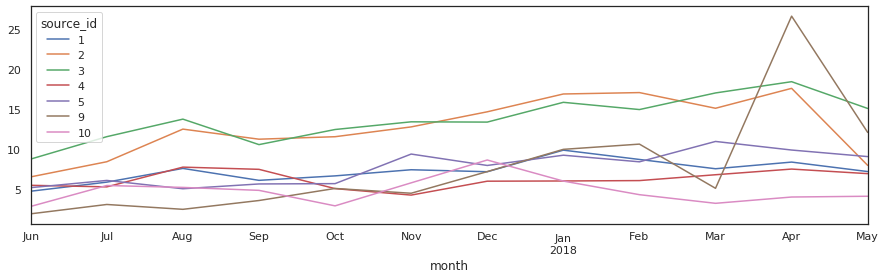

In [33]:
fig, ax = plt.subplots(figsize=(15,4))
pd.pivot_table(report_cost_month,
              index ='month',
              columns = 'source_id',
              values='cac',
              aggfunc='mean').plot (ax=ax)
plt.show()

В среднем для всего проекта один покупатель обходится в 9.01 y.e. Дороже всего обходятся покупатели привлекаемые с помощью источника №2 и источника №3. В апреле'18 стоимость привлечения одного покупателя для источник №9 обошлась слишком дорго и составила 26.7 y.e.

-----

#### Рассчитаем ROMI по когортам в разрезе источников. Сравним окупаемость за одинаковые периоды жизни когорт. Построим графики, отражающие изменения метрик во времени.

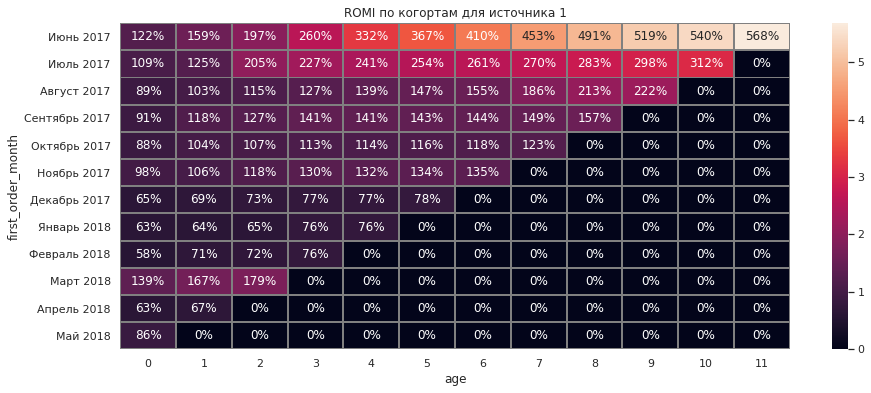

Средний ROMI по когортам на 6 месяц жизни: 204%


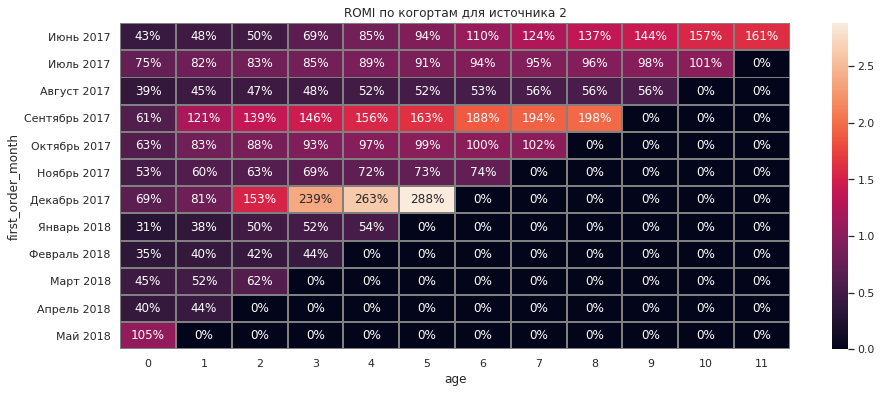

Средний ROMI по когортам на 6 месяц жизни: 103%


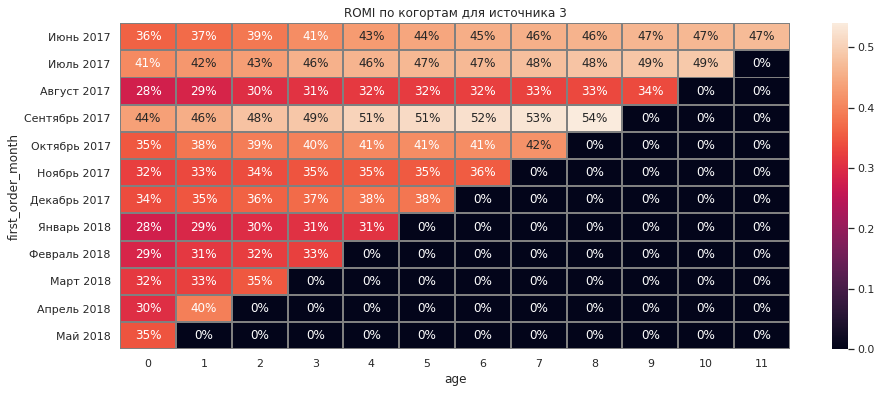

Средний ROMI по когортам на 6 месяц жизни: 42%


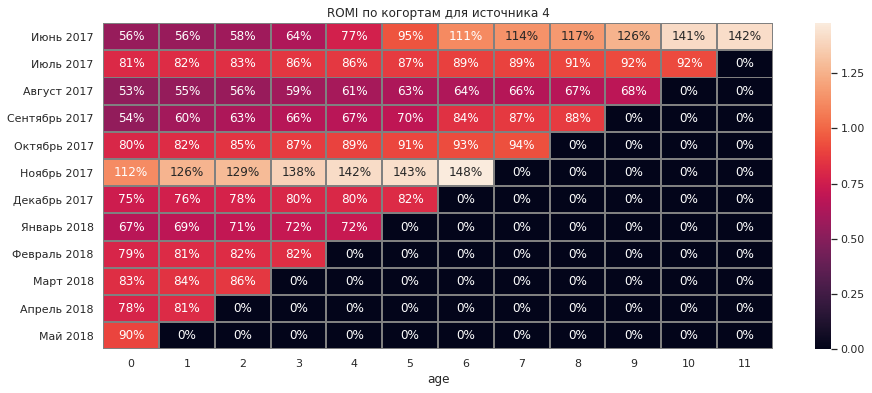

Средний ROMI по когортам на 6 месяц жизни: 98%


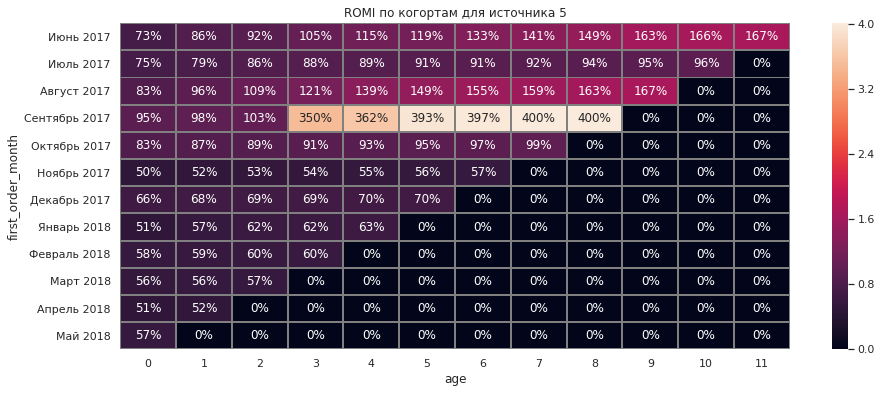

Средний ROMI по когортам на 6 месяц жизни: 155%


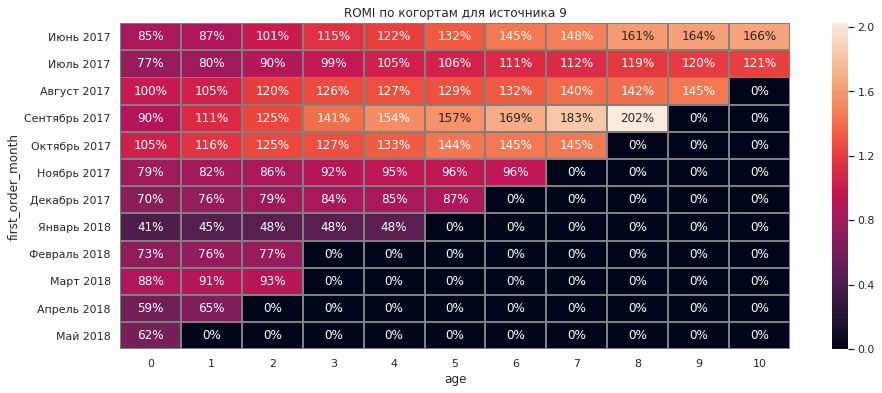

Средний ROMI по когортам на 6 месяц жизни: 133%


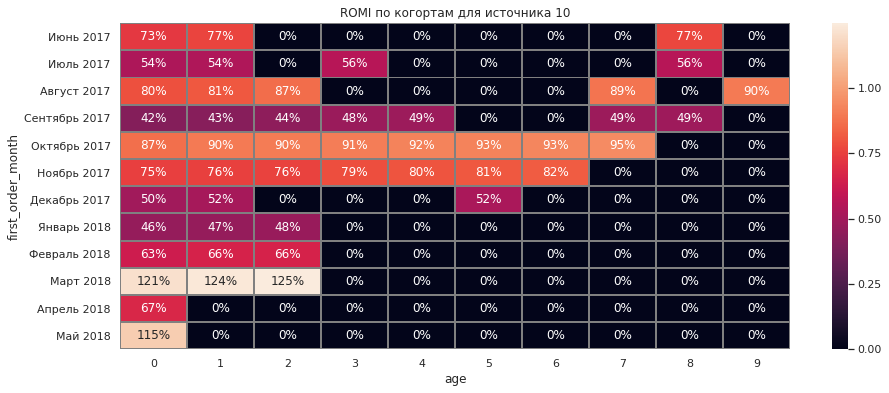

Средний ROMI по когортам на 6 месяц жизни: 88%


In [37]:
def Romi(source):
    source_users = users.query('source_id == @source').index.values
    source_orders = orders.query('uid in @source_users')

    cohort_sizes = (
        source_orders.groupby('first_order_month')
        .agg({'uid': 'nunique'})
        .reset_index()
    )
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
    cohorts = (
        source_orders.groupby(['first_order_month', 'order_month'])
        .agg({'revenue':'sum'})
        .reset_index()
    )
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

    margin_rate = 1
    report['gp'] = report['revenue'] * margin_rate
    report['ltv'] = report['gp'] / report['n_buyers']
    report['age'] = (
        report['order_month'] - report['first_order_month']
    ) / np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')
    output = report.pivot_table(
        index='first_order_month', columns='age', values='ltv', aggfunc='mean'
    )
    output = output.cumsum(axis=1).fillna(0)
    
    source_costs = costs.query('source_id == @source')
    source_costs = source_costs.groupby('month').agg({'costs':'sum'})
    source_costs = source_costs.join(cohort_sizes.set_index('first_order_month'))
    source_costs['cac'] = source_costs['costs'] / source_costs['n_buyers']
    
    sns.set(style='white')
    plt.figure(figsize=(15, 6))
    plt.title('ROMI по когортам для источника {}'.format(source))
    plt.xlabel('Lifetime')
    plt.ylabel('Когорты')
    y_axis_labels = ['Июнь 2017','Июль 2017','Август 2017','Сентябрь 2017','Октябрь 2017','Ноябрь 2017'
                     ,'Декабрь 2017','Январь 2018','Февраль 2018','Март 2018','Апрель 2018','Май 2018'] 

    sns.heatmap(output.div(source_costs['cac'],axis=0).dropna()
                , annot=True, fmt='.0%', linewidths=1, linecolor='gray', yticklabels=y_axis_labels)
    
    return plt.show(), print('Средний ROMI по когортам на 6 месяц жизни: {:.0%}'.format(output.div(source_costs['cac'],axis=0).replace(0, np.NaN)[6].mean()))

sources = [1, 2, 3, 4, 5, 9, 10]
for source in sources: 
    Romi(source)
    

Построив графики и сравнив окупаемости за период в 6 месяцев можно сделать следующие выводы:
 - В среднем практически все когорты пришедшие из различных источников окупаются к 6 месяцу, исключениями являются: источник №3 - **42%**, источник №4 - **98%**.
 - Самым окупаемым источником, является источник №1, к 6 месяцу когорты с этого источника в среднем окупились в 2 раза.
 -  По источнику №10 не хватает данных что бы сделать выводы.
---


## 3. Выводы и рекомендации

В холодное время года, а именно в период с сентября по апрель увеличивается количество уникальных пользователей. Пик сезона приходится на декабрь. Пользователи заходят на сайт в среднем чуть больше одного раза и проводят на нём около **5** минут. Retention Rate пользователей из более ранних когорт выше и они охотнее возвращаются в последующие периоды. 
    
    
Практически все покупки совершаются в течении суток, в среднем для совершения покупки пользователям требуются **16** минут. На 6 месяц жизни когорт, в среднем пользователь совершает **1.5** покупки. Самый высокий средний чек приходится на декабрь, что совпадает с пиком пользовательской активности. На 6 месяц жизни когорт, один пользователь в среднем приносит **8.39** y.e.


Стоит пересмотреть маркетинговую политику в отношении источника №3, на него выделяется бюджет в **141 321** y.e., что составляет **42.9%** от общего количества расходов. Однако ни одна из когорт привлеченная с помощью этого источника не окупилась, а средняя окупаемость к 6 месяцу составляет **42%**. Освободившийся бюджет следуюет перераспределить в следующие источники:
 - источник №1, к 6 месяцу он окупается на **204%**;
 - сточник №5 с окупаемостью в **155%** к 6 месяцу;
 - источник №9, окупаемость к 6 месяцу **133%**;